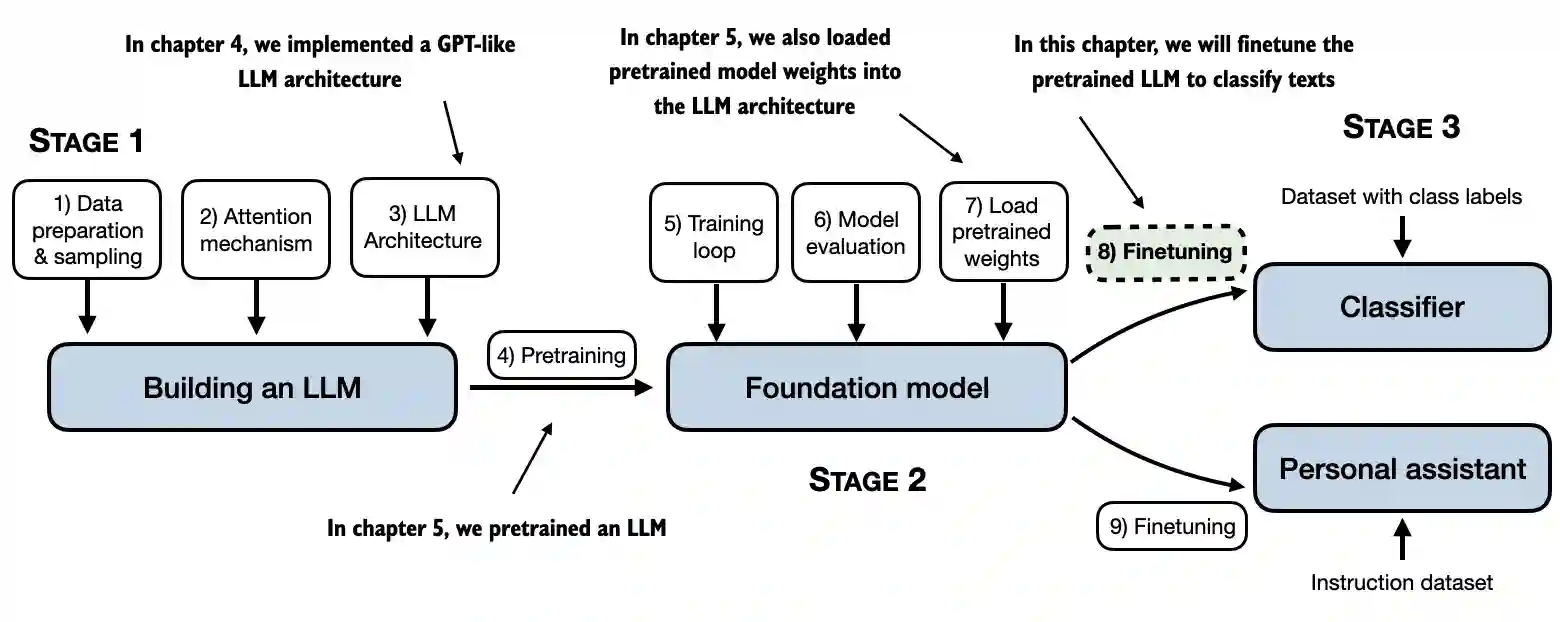

**Instruction-finetuning**

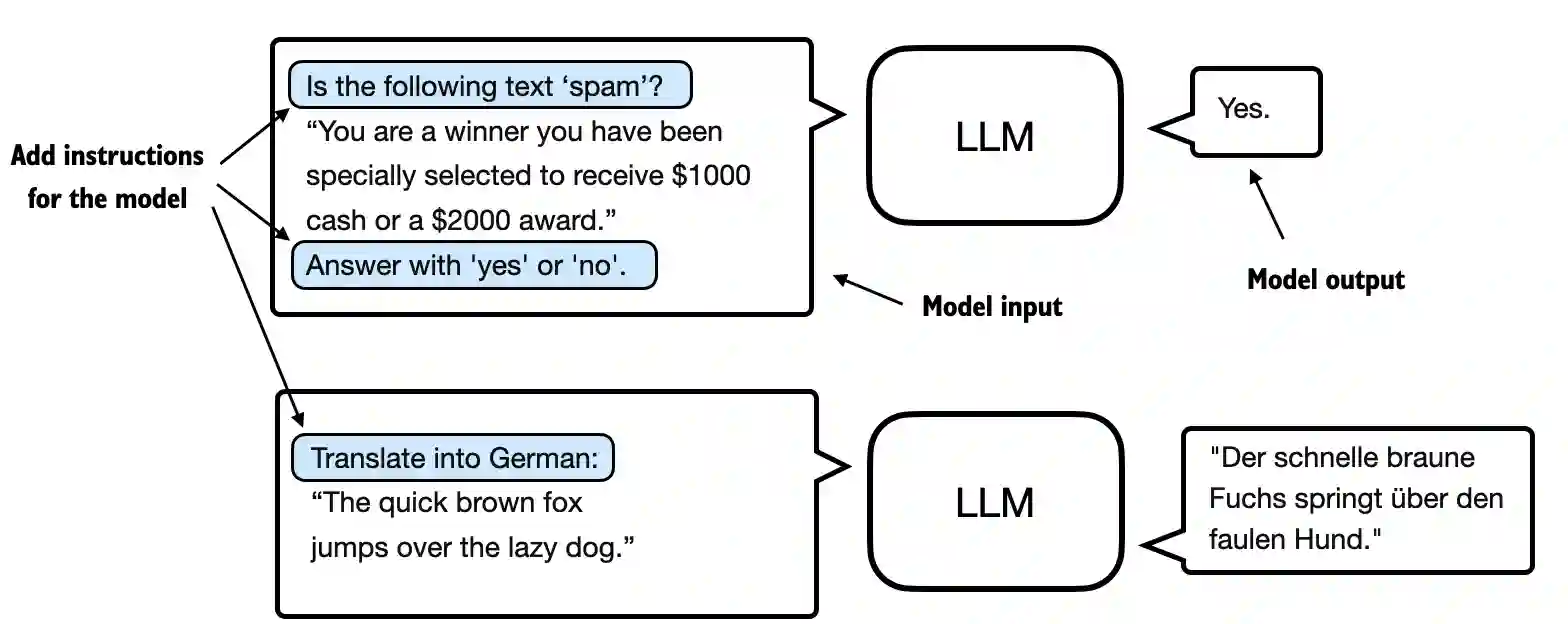

**Classification-finetuning**

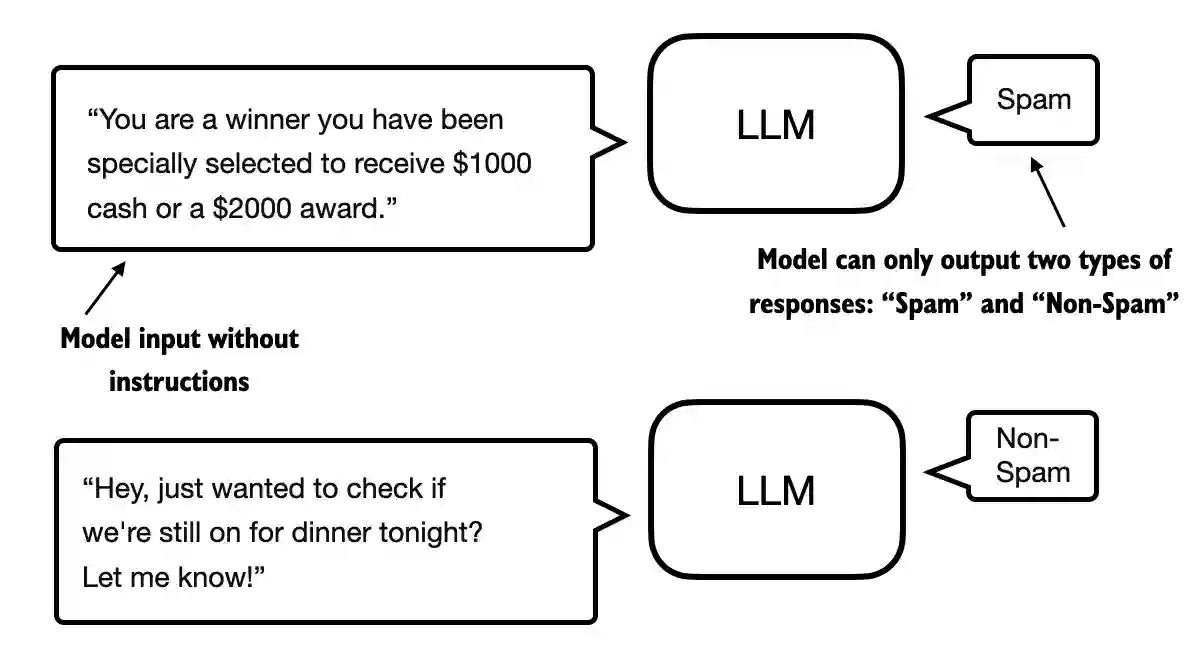

# 1. Classification Finetuning

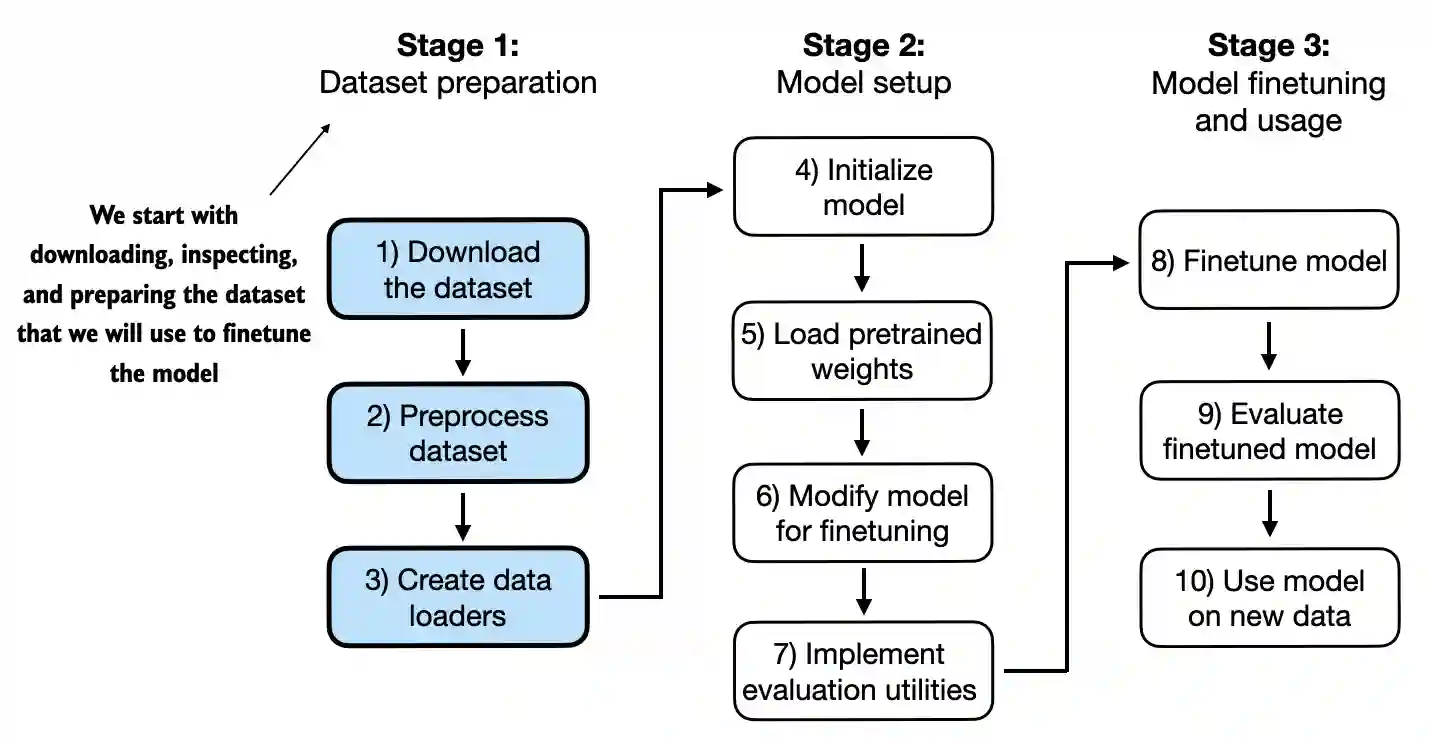

## DownLoad Dataset

In [63]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "data/sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Downloading the file
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

try:
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (urllib.error.HTTPError, urllib.error.URLError, TimeoutError) as e:
    print(f"Primary URL failed: {e}. Trying backup URL...")
    url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path) 

data/sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


## PreProcessing

In [64]:
import pandas as pd 

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

Label                                               Text
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5567  spam  This is the 2nd time we have tried 2 contact u...
5568   ham               Will ü b going to esplanade fr home?
5569   ham  Pity, * was in mood for that. So...any other s...
5570   ham  The guy did some bitching but I acted like i'd...
5571   ham                         Rofl. Its true to its name

[5572 rows x 2 columns]

In [65]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [66]:
def create_balanced_dataset(df):
    num_spam = df[df["Label"]=="spam"].shape[0]

    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)

    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [67]:
balanced_df["Label"] = balanced_df["Label"].map({"ham":0, "spam":1})
balanced_df

Label                                               Text
4307      0  Awww dat is sweet! We can think of something t...
4138      0                             Just got to  &lt;#&gt;
4831      0  The word "Checkmate" in chess comes from the P...
4461      0  This is wishing you a great day. Moji told me ...
5440      0      Thank you. do you generally date the brothas?
...     ...                                                ...
5537      1  Want explicit SEX in 30 secs? Ring 02073162414...
5540      1  ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547      1  Had your contract mobile 11 Mnths? Latest Moto...
5566      1  REMINDER FROM O2: To get 2.50 pounds free call...
5567      1  This is the 2nd time we have tried 2 contact u...

[1494 rows x 2 columns]

In [68]:
def random_split(df, train_frac, validation_frac):
    # shuffle the entire datafram
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)
    
    train_end = int(len(df) * train_frac)
    validation_end = int(train_end +  int(len(df)*validation_frac))

    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
train_df.to_csv("data/train.csv", index=None)
validation_df.to_csv("data/validation.csv", index=None)
test_df.to_csv("data/test.csv", index=None)


## DataLoader

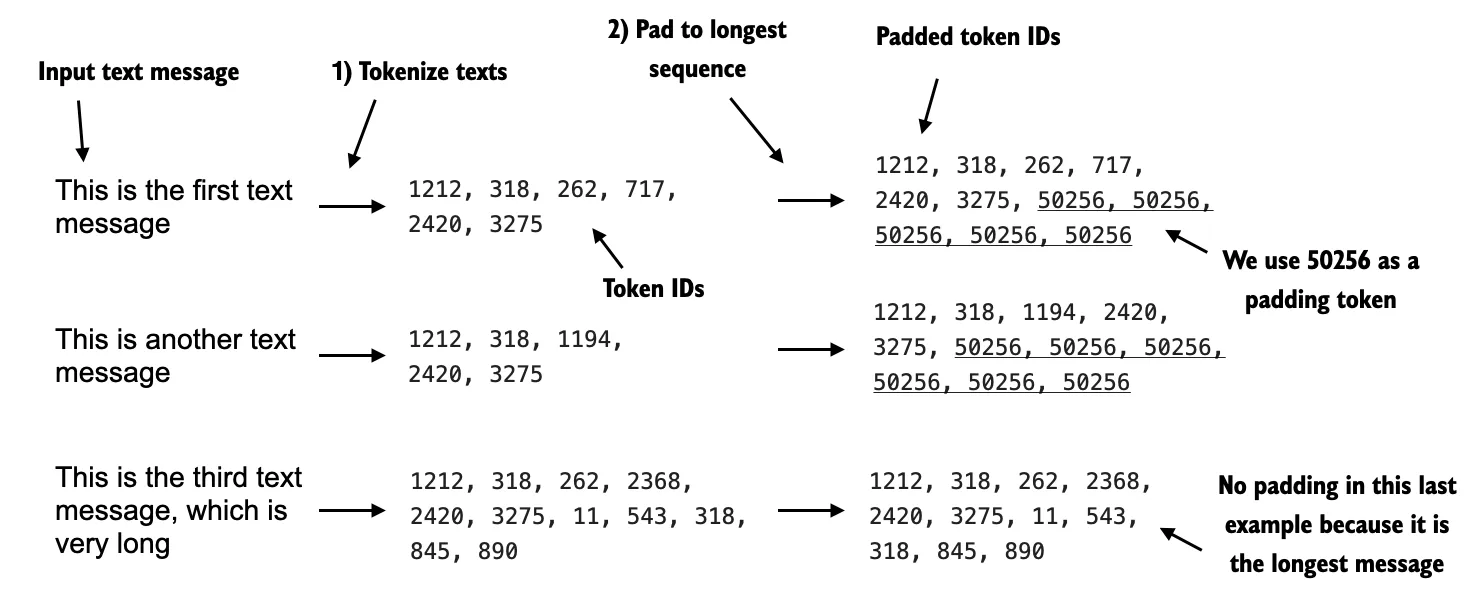

In [69]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


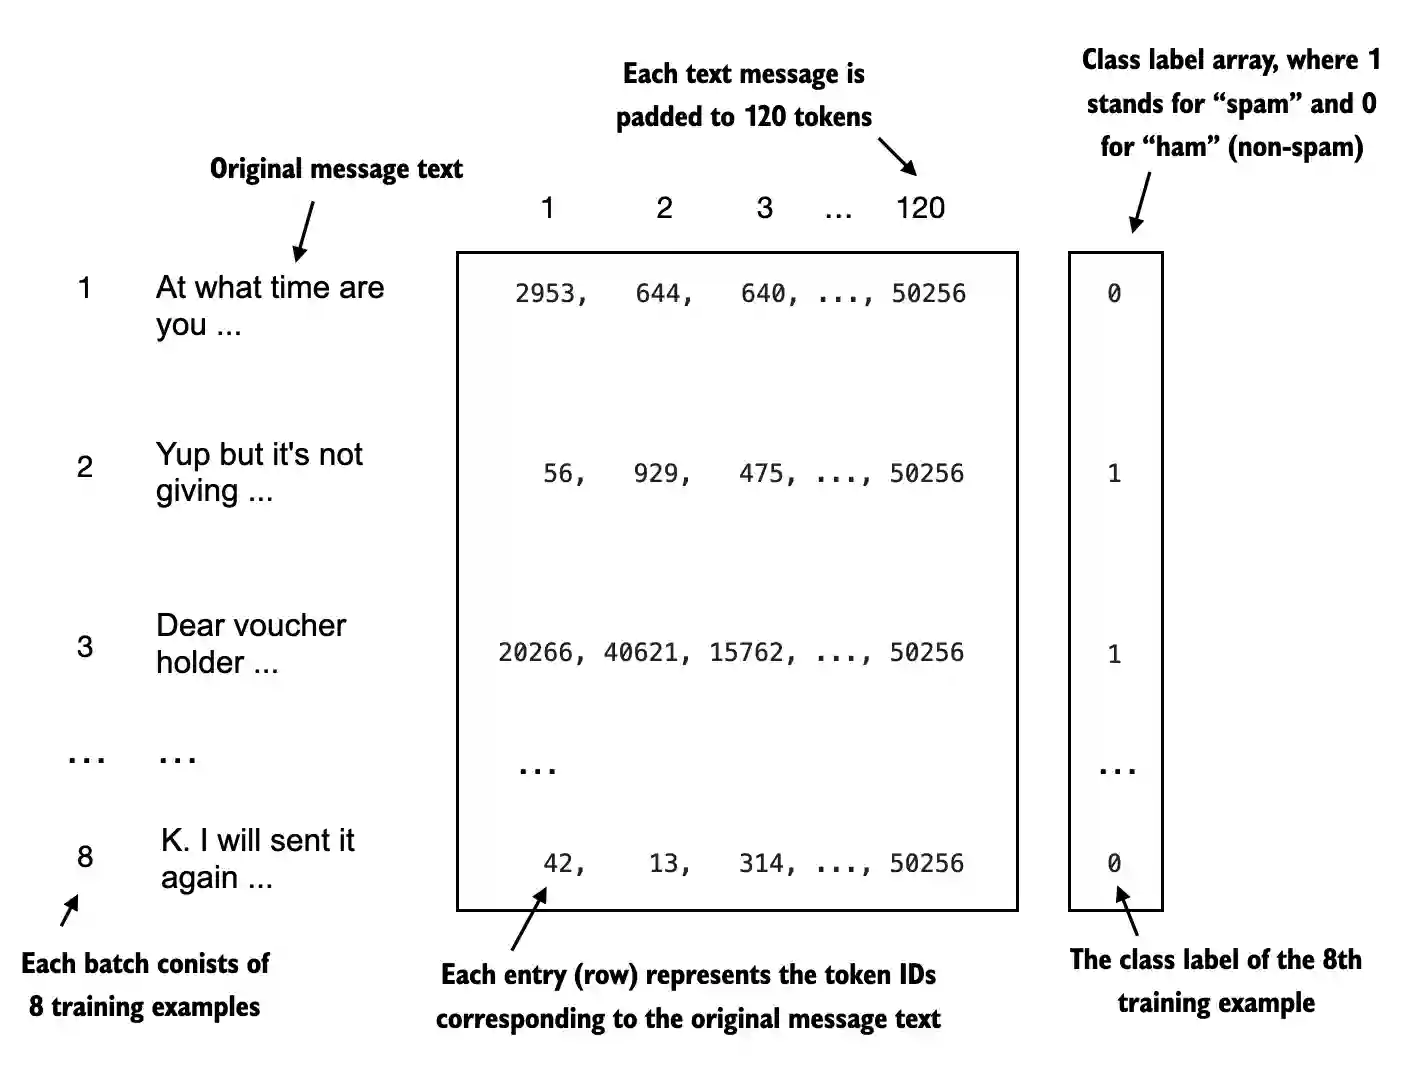

In [ ]:
#XXX SpamDataset:Classifier Finetuning

import torch
from torch.utils.data import Dataset 

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data['Text']
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length() # 自身最长为最长
        else:
            self.max_length = max_length

            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        self.encoded_texts = [
            encoded_text + [pad_token_id]*(self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]
    
    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]

        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )
    
    def __len__(self):
        return len(self.data)
    
    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [71]:
train_dataset = SpamDataset(
    csv_file="data/train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

120


In [72]:
val_dataset = SpamDataset(
    csv_file="data/validation.csv",
    max_length=train_dataset.max_length, # 截断到trainset的max_length
    tokenizer=tokenizer
)

test_dataset = SpamDataset(
    csv_file="data/test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

print(test_dataset.max_length)

120


In [73]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)

In [74]:
print("Train_loader")

for input_batch, target_batch in train_loader:
   pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions:", target_batch.shape)


Train_loader
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions: torch.Size([8])


In [75]:
print(f"Number of batches: {len(train_loader)}")
print(f"Sampler: {train_loader.sampler}")
print(f"Dataset: {train_loader.dataset}")

Number of batches: 130
Sampler: <torch.utils.data.sampler.RandomSampler object at 0x70fe2db552b0>
Dataset: <__main__.SpamDataset object at 0x70fe2dc124f0>


In [76]:
print(len(test_loader))
print(len(val_loader))

38
19


In [77]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [78]:
import tensorflow as tsf
import tqdm
from GPT import GPTModel
from GPT import load_weights_into_gpt
from gpt_download3 import download_and_load_gpt2

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

/home/wangjz/miniforge3/envs/llm/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/checkpoint


/home/wangjz/miniforge3/envs/llm/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/encoder.json


/home/wangjz/miniforge3/envs/llm/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/hparams.json


/home/wangjz/miniforge3/envs/llm/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001


/home/wangjz/miniforge3/envs/llm/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.index


/home/wangjz/miniforge3/envs/llm/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.meta


/home/wangjz/miniforge3/envs/llm/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiheadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiheadAttention(
        (W_query): Linear(in_features=7

In [79]:
from GPT import text_to_token_ids, token_ids_to_text, generate_text_simple

text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx = text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [80]:
text_2 = (
    "Is the following text 'spam'? Anser with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG['context_length']   
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Anser with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

'You have been specially selected to receive $1000 cash or a $2000 award.' 'You have been


## Modify model

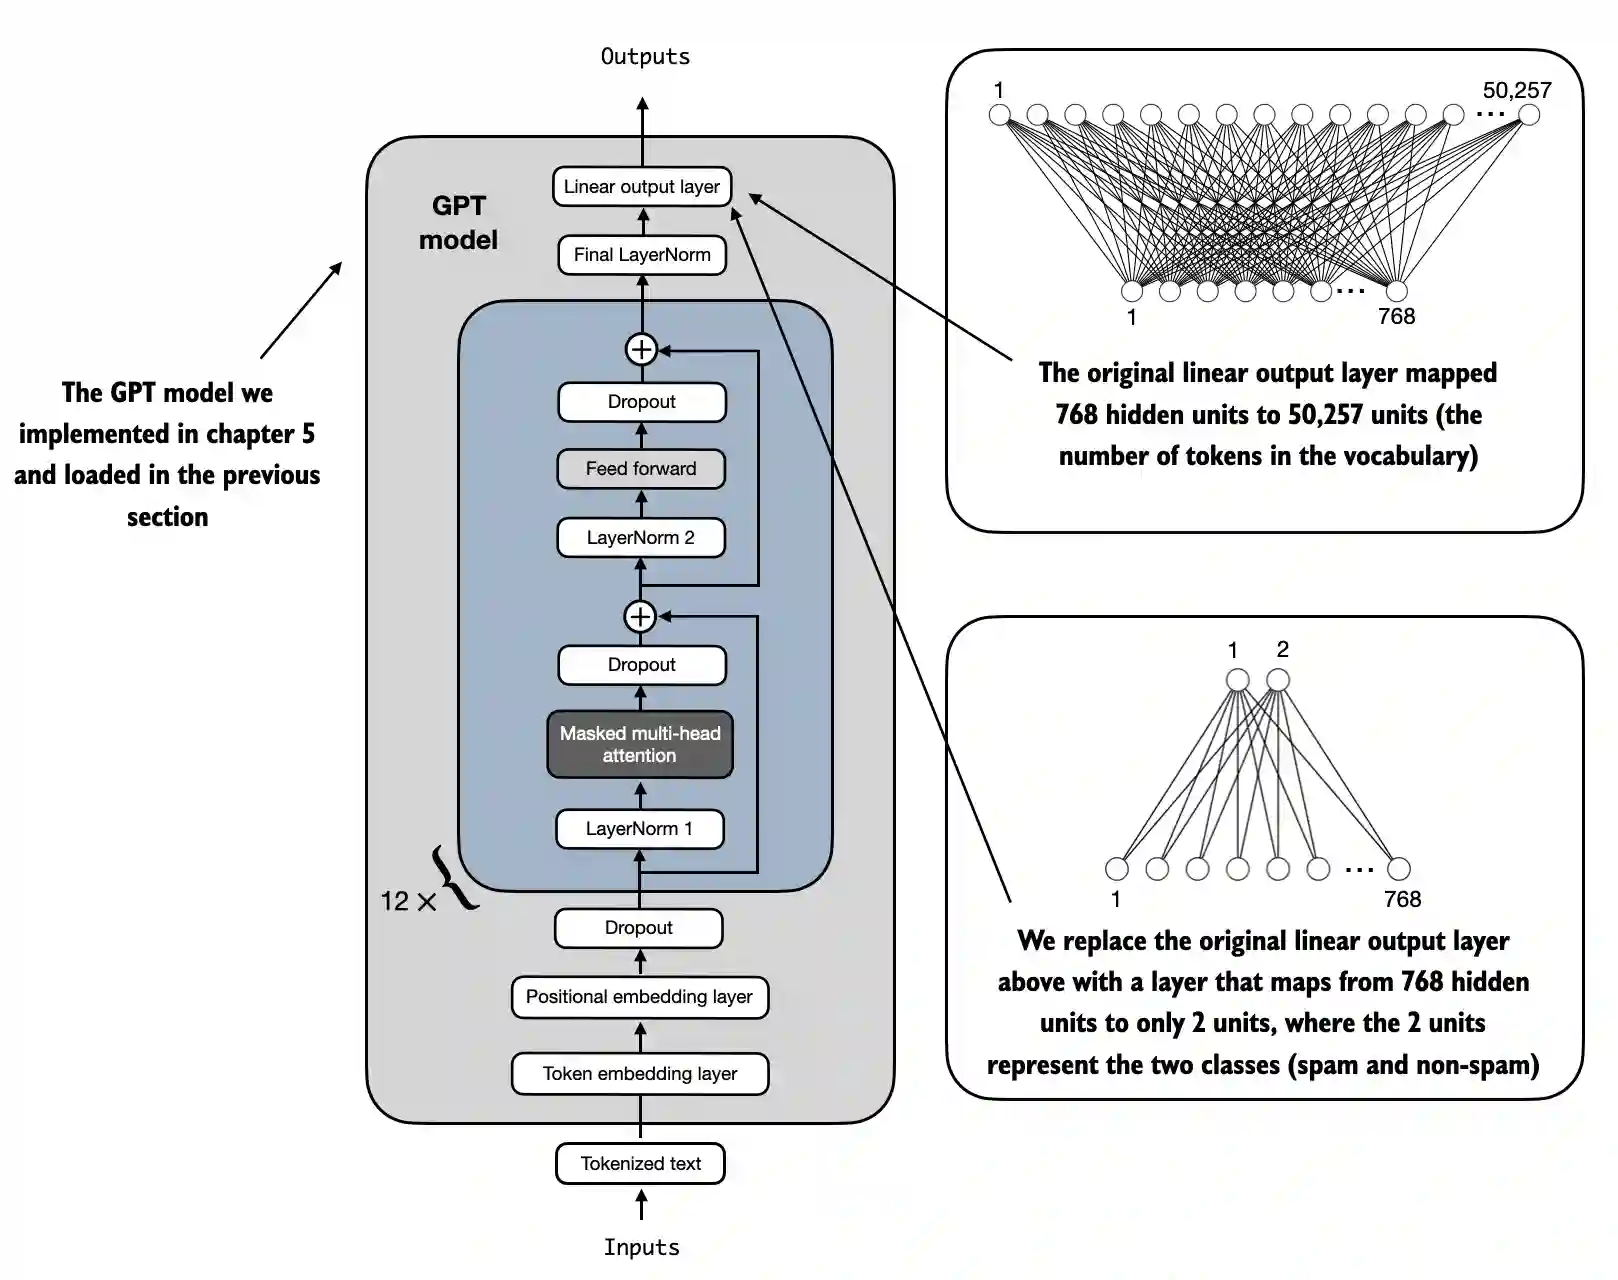

In [81]:
for param in model.parameters():
    param.requires_grad = False

torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG['emb_dim'],
    out_features=num_classes
)

for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

In [82]:
inputs = tokenizer.encode("Do you have time")
print(inputs)
print(len(inputs))
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs dimensions:", inputs.shape)

[5211, 345, 423, 640]
4
Inputs dimensions: torch.Size([1, 4])


In [83]:
with torch.no_grad():
    outputs = model(inputs)

print(outputs)
print("Output dimensions:", outputs.shape)
print("Last")

tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Output dimensions: torch.Size([1, 4, 2])
Last


In [84]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


In [85]:
probas = torch.softmax(outputs[:,-1,:], dim=-1)
print(probas)
label = torch.argmax(probas)
print("clas  label:", label.item())

tensor([[5.0598e-04, 9.9949e-01]])
clas  label: 1


**Logits：[batch_size, seq_len, vocab_size]**

[["every", "effort", "moves", "you"],

 ["Night", "on", "sun", "goes"]]

[2, 4, 50257]

Logits[:, -1 , :] = [50257]-->forward, [50257]-->down

shuffle 会调换sample的顺序，batch_size就是一个batch中有几个sample， 但是不会改变sample内部的token顺序

In [86]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_expampels = 0,0
    
    # 设置num_batches主要目的是防止dataloader中的数据过多，每次计算消耗大量资源和时间。
    # 设定一个范围在dataloader中，根据数据范围内的损失，来进行优化。设置num_batches（eval_iter）,其平均损失作为验证损失
    # 要防止dataloader的自身长度小于咱们设置的范围，所以谁小用谁

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]
            proba = torch.softmax(logits, dim=-1)
            predict_label = torch.argmax(proba, dim=-1)

            num_expampels += predict_label.shape[0]
            correct_predictions += (predict_label == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_expampels
        

In [87]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
torch.manual_seed(123)

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)


print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [88]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:,-1,:]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [89]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss=0
    if len(data_loader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [90]:
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)


print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322


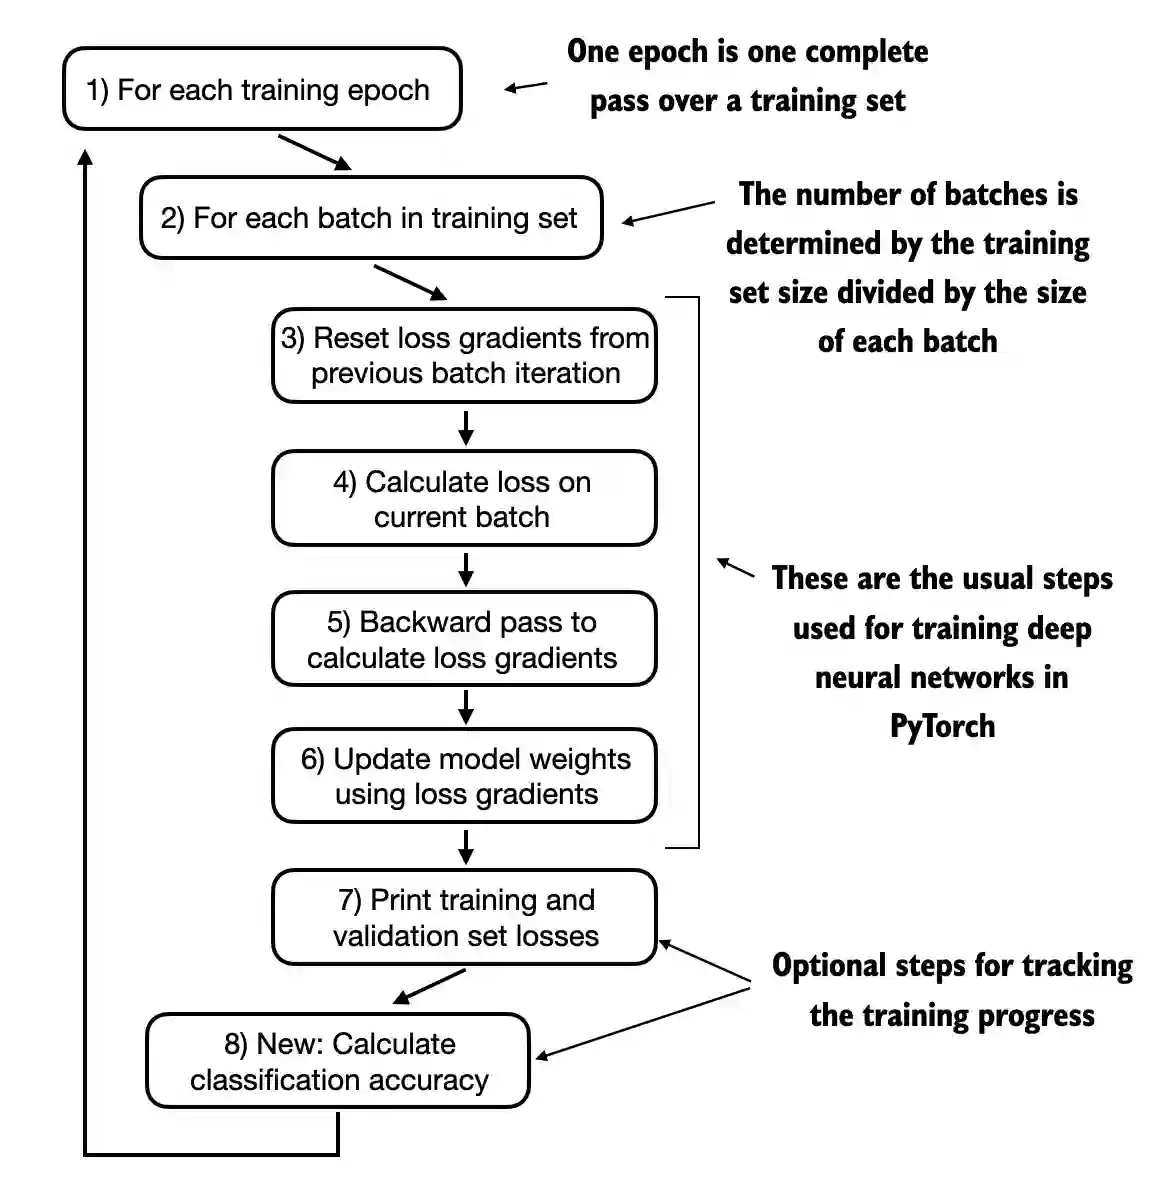

In [91]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # 训练神经网络时梯度会累计，在计算梯度前要将梯度清零
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # 反向传播计算各参数梯度
            optimizer.step() # 进行梯度下降，更新参数
            examples_seen += input_batch.shape[0] # 看了几个sample，即sequence
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device,  eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)

                # 一个epoch多个eval验证节点
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")

        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss 
        

In [92]:
import time 

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.1) # 控制模型复杂度的正则化参数，L2 正则化（权重衰减）的系数，通过对大权重施加惩罚，防止模型过拟合。

num_epochs = 5

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, test_loader, optimizer, device,
    num_epochs=num_epochs,
    eval_freq=50, eval_iter=5
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 1.977, Val loss 1.975
Ep 1 (Step 000050): Train loss 0.612, Val loss 0.613
Ep 1 (Step 000100): Train loss 0.427, Val loss 0.487
Training accuracy: 85.00% | Validation accuracy: 85.00%
Ep 2 (Step 000150): Train loss 0.715, Val loss 0.719
Ep 2 (Step 000200): Train loss 0.362, Val loss 0.420
Ep 2 (Step 000250): Train loss 0.323, Val loss 0.376
Training accuracy: 87.50% | Validation accuracy: 87.50%
Ep 3 (Step 000300): Train loss 0.191, Val loss 0.304
Ep 3 (Step 000350): Train loss 0.123, Val loss 0.299
Training accuracy: 100.00% | Validation accuracy: 92.50%
Ep 4 (Step 000400): Train loss 0.026, Val loss 0.295
Ep 4 (Step 000450): Train loss 0.020, Val loss 0.324
Ep 4 (Step 000500): Train loss 0.150, Val loss 0.349
Training accuracy: 100.00% | Validation accuracy: 92.50%
Ep 5 (Step 000550): Train loss 0.119, Val loss 0.263
Ep 5 (Step 000600): Train loss 0.016, Val loss 0.334
Training accuracy: 97.50% | Validation accuracy: 95.00%
Training completed in 0.63 mi

In [93]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

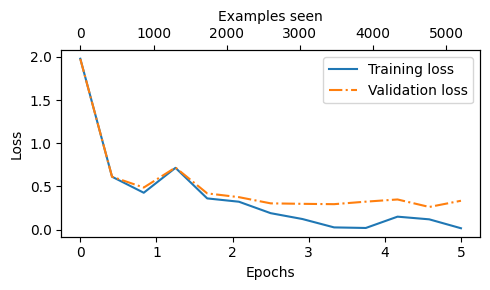

In [94]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

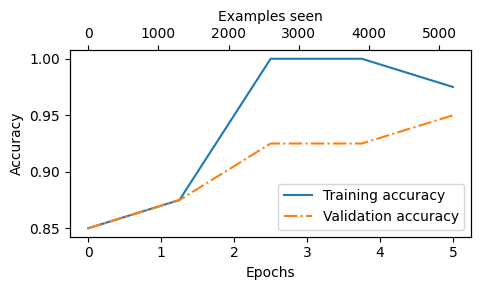

In [95]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [96]:
# dataloader全部数据

train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 98.27%
Validation accuracy: 98.66%
Test accuracy: 97.00%


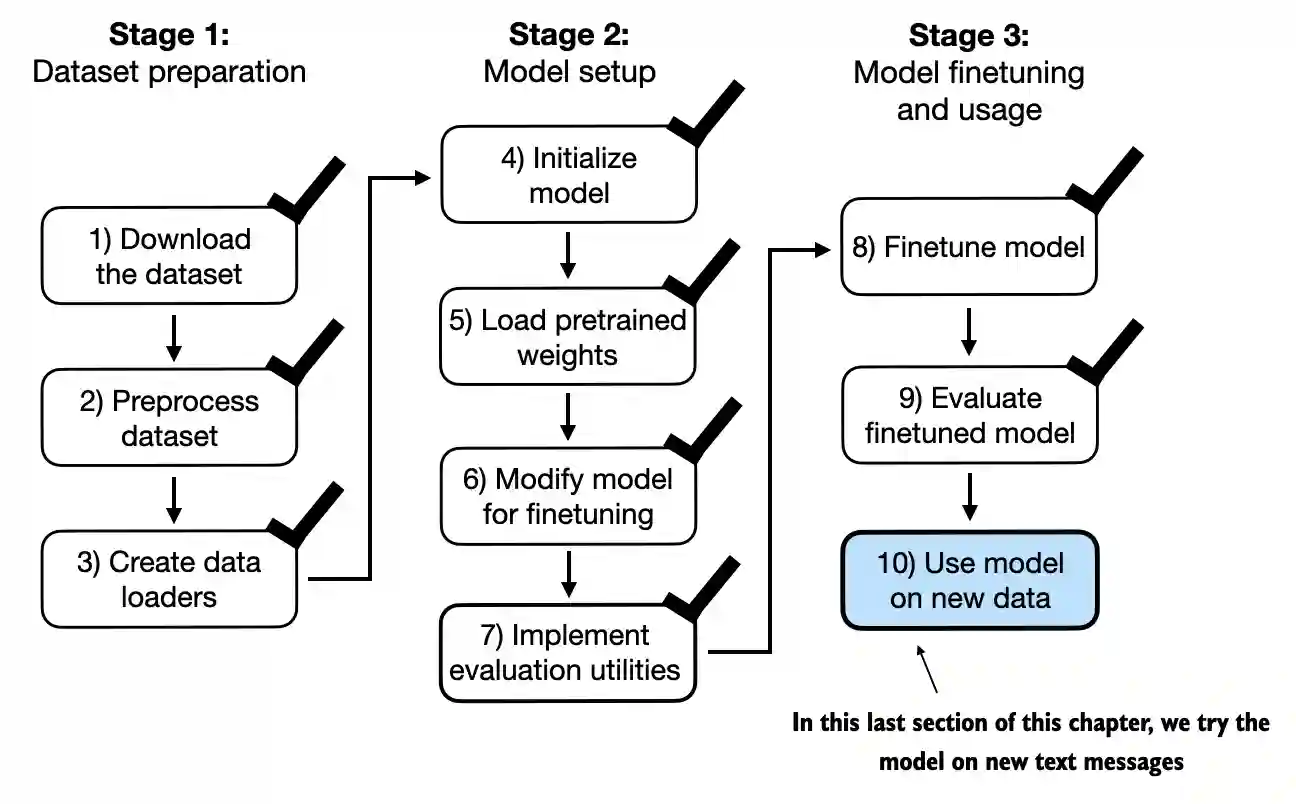

In [ ]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0] # 之前设定的context_length

    input_ids = input_ids[:min(max_length, supported_context_length)]

    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)

    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]
    predicted_label = torch.argmax(logits, dim=-1).item()

    return "spam" if predicted_label == 1 else "not spam"

In [101]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [102]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


# 2. Instruction Finetuning